In [3]:
import os
import re
import glob
import jieba
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

Goal of this notebook:  
(1) Organize scraped data  
https://mp.weixin.qq.com/s/Q2uLXEiq7u3Jq1dZJ9qa5w  
(2) Return edge and node lists for Gephi  
tutorial: https://gephi.org/users/supported-graph-formats/spreadsheet/  

In [72]:
# 合并每个文档下面的所有csv文件

def combineData(folderName):
    file_list = glob.glob("liuqiangdong-hot/" + folderName + "/*")
    
    file_list_ = []
    for item in file_list:
        weishengjing = (
            pd.read_csv(item)
            .assign(
                root_mid = str(item).split('/')[2].replace(".csv","")
            )
            .loc[
                lambda x: x['forward_num'] > 0
            ]
        )

        file_list_.append(weishengjing)

    df = pd.concat(file_list_)
    
    return df

In [631]:
# original posts
root_df = (
    pd.read_csv("liuqiangdong-hot/0th_原贴/original_with.csv")
    .rename(columns={'link':'weibo_link','type':'weibo_type'})
    .assign(
        publish_time = np.nan,
        user_link = np.nan,
        forward_num = np.nan,
        comment_num = np.nan,
        like_num = np.nan,
        root_mid = np.nan
    )
)
root_df.head(1)

,mid,user_name,weibo_type,weibo_link,content,publish_time,user_link,forward_num,comment_num,like_num,root_mid
0,4820093098264539,界面新闻,pro-qiangdong,https://weibo.com/5182171545/M8qIdyFZ1?refer_f...,【#刘强东明州事件双方以和解终结#】刘强东明州案迎来意外转折，北美时间10月1日晚间双方律师...,NaN,NaN,NaN,NaN,NaN,NaN


In [379]:
df = pd.concat(df_list)

# 合并forwarded content 
df = df.append(root_df)
len(df)

,mid,publish_time,user_name,user_link,content,weibo_link,forward_num,comment_num,like_num,root_mid
0,4820095886951506,2022-10-02 12:11:15,午后狂睡,https://weibo.com/u/1253846303,[吃瓜]和解了。,https://weibo.com/1253846303/M8qMItap4,247,243,2157,4820093098264539
1,4820110622330529,2022-10-02 13:09:48,dede-lab,https://weibo.com/u/2518847513,看到这个标题都知道会有多少人用吃瓜表情嘲讽女生，和解不是无罪，庭审记录里事实确凿，请停止污名...,https://weibo.com/2518847513/M8rau9Mhb,173,74,1462,4820093098264539


In [444]:
# 删除一开始多加进去的点
# based on Gephi data (因为在gephi中手动删除了一些)

# node_keep_list = pd.read_csv("liuqiangdong-hot-export/gephi_node_hot_posts_only_by_hand.csv")['Id'].tolist()
# df_keep = (
#     df[df['mid'].astype(int).isin(node_keep_list)]
#     .drop_duplicates(subset=['mid'])
#     .reset_index(drop=True)
#     [['mid', 'publish_time', 'user_name', 'user_link', 'content',
#        'weibo_link', 'forward_num', 'comment_num', 'like_num', 'root_mid']]
# )

# df_keep.to_csv("liuqiangdong-hot-export/df_keep.csv", encoding="utf-8")

In [455]:
# 读取自己分好类的type
# 这是给Node list用的

df_keep_with_type = (
    pd.read_csv("liuqiangdong-hot-export/df_keep_with_type.csv")
    .assign(
        weibo_type = lambda x: x['weibo_type'].fillna('pro_qiangdong')
    )
    .drop(columns=['Unnamed: 0'])
)

df_keep_with_type.head(2)

,mid,publish_time,user_name,user_link,content,weibo_type,weibo_link,forward_num,comment_num,like_num,root_mid
0,4820095886951506,2022-10-02 12:11:15,午后狂睡,https://weibo.com/u/1253846303,[吃瓜]和解了。,pro_qiangdong,https://weibo.com/1253846303/M8qMItap4,247,243,2157,4820093098264539
1,4820110622330529,2022-10-02 13:09:48,dede-lab,https://weibo.com/u/2518847513,看到这个标题都知道会有多少人用吃瓜表情嘲讽女生，和解不是无罪，庭审记录里事实确凿，请停止污名...,pro_jingyao,https://weibo.com/2518847513/M8rau9Mhb,173,74,1462,4820093098264539


In [647]:
# everything with a type!!

df_keep_combine = (
    df_keep_with_type.append(root_df)
    .loc[
        lambda x: x['weibo_type']!='deleted'
    ]
    .assign(
        weibo_type = lambda x:x['weibo_type'].str.replace("-","_").str.replace("pro_jingyao",'pro-feminism').str.replace("pro_qiangdong",'anti-feminism')
    )
)
df_keep_combine.head(2)

,mid,publish_time,user_name,user_link,content,weibo_type,weibo_link,forward_num,comment_num,like_num,root_mid
0,4820095886951506,2022-10-02 12:11:15,午后狂睡,https://weibo.com/u/1253846303,[吃瓜]和解了。,anti-feminism,https://weibo.com/1253846303/M8qMItap4,247.0,243.0,2157.0,4.820093e+15
1,4820110622330529,2022-10-02 13:09:48,dede-lab,https://weibo.com/u/2518847513,看到这个标题都知道会有多少人用吃瓜表情嘲讽女生，和解不是无罪，庭审记录里事实确凿，请停止污名...,pro-feminism,https://weibo.com/2518847513/M8rau9Mhb,173.0,74.0,1462.0,4.820093e+15


In [653]:
df_keep_combine.sort_values(by='forward_num', ascending=False)

,mid,publish_time,user_name,user_link,content,weibo_type,weibo_link,forward_num,comment_num,like_num,root_mid
168,4820136555185309,2022-10-02 14:52:51,是Ka什么ya,https://weibo.com/u/1839112730,首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和解。其次...,pro-feminism,https://weibo.com/1839112730/M8rQjlKW1,392.0,20.0,123.0,4.820093e+15
257,4820108625314290,2022-10-02 13:01:51,小江同学去北京,https://weibo.com/u/7559222732,偶然事件指的是：刘先生酒后不慎摔倒，生殖器意外的跌进了刘女士的阴道里面。因刘先生患有早泄，无...,pro-feminism,https://weibo.com/7559222732/M8r7gmium,275.0,13.0,74.0,4.820093e+15
0,4820095886951506,2022-10-02 12:11:15,午后狂睡,https://weibo.com/u/1253846303,[吃瓜]和解了。,anti-feminism,https://weibo.com/1253846303/M8qMItap4,247.0,243.0,2157.0,4.820093e+15
1,4820110622330529,2022-10-02 13:09:48,dede-lab,https://weibo.com/u/2518847513,看到这个标题都知道会有多少人用吃瓜表情嘲讽女生，和解不是无罪，庭审记录里事实确凿，请停止污名...,pro-feminism,https://weibo.com/2518847513/M8rau9Mhb,173.0,74.0,1462.0,4.820093e+15
2,4820114526705340,2022-10-02 13:25:19,互联网俊明说,https://weibo.com/u/1746575865,10月3号开庭，目前和解了。[doge],anti-feminism,https://weibo.com/1746575865/M8rgMs8mE,168.0,245.0,972.0,4.820093e+15
...,...,...,...,...,...,...,...,...,...,...,...
29,4820127222858882,NaN,搂着房照睡的香,NaN,大强子就是有人格魅力！《刘强东、刘婧尧明州事件双方和解，称是误会》IT之家 10 月 2 日...,anti-feminism,https://weibo.com/5874240306/M8rBgbZJ0?refer_f...,NaN,NaN,NaN,NaN
30,4820147229168627,NaN,voiceyaya,NaN,对jingyao来说，也不算是失败，至少逼得刘强东妥协了一部分。这个当然不只是靠她自己，也有...,pro-feminism,https://weibo.com/1542701343/M8s7wCtb5?refer_f...,NaN,NaN,NaN,NaN
31,4819170842117454,NaN,Kevin在纽约,NaN,NYT：刘强东案民事诉讼将于下月初在美国明尼阿波利斯开庭，上周末，刘强东和他怀孕的妻子被人拍...,anti-feminism,https://weibo.com/6479869715/M82II8SQu?refer_f...,NaN,NaN,NaN,NaN
32,4820920671141909,NaN,庚白星君,NaN,刘强东明州案又有了一点尾声。今天有个媒体根据控辩双方在美国法庭提交的证据，把女方liu ji...,anti-feminism,https://weibo.com/6399245004/M8Mf14N3T?refer_f...,NaN,NaN,NaN,NaN


Text(0.5, 0, 'type')

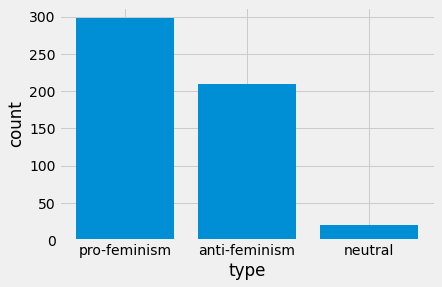

In [648]:
weibo_type = df_keep_combine['weibo_type'].value_counts().reset_index()

plt.bar(weibo_type['index'], weibo_type['weibo_type'])
plt.ylabel("count")
plt.xlabel("type")

In [499]:
# 各种node的数量

print('pro_jingyao:' + str(len(df_keep_with_type[df_keep_with_type['weibo_type']=='pro_jingyao'])))
print('pro_jingyao_unique: ' + str(len(df_keep_with_type[df_keep_with_type['weibo_type']=='pro_jingyao'].drop_duplicates(subset='user_link'))))
print('pro_qiangdong:' + str(len(df_keep_with_type[df_keep_with_type['weibo_type']=='pro_qiangdong'])))
print('neutral:' + str(len(df_keep_with_type[df_keep_with_type['weibo_type']=='neutral'])))

pro_jingyao:291
pro_jingyao_unique: 287
pro_qiangdong:189
neutral:19


## Analyze Weibo User Profiles

In [511]:
# User followers!
type_dict = dict(zip(df_keep_with_type['mid'], df_keep_with_type['weibo_type']))

followers = (
    pd.read_csv("liuqiangdong-user/added_weibo_detail_result.csv")
    .drop(columns={'Unnamed: 0', 'Unnamed: 0.1'})
    .rename(columns={'wid':'mid'})
    .assign(
        weibo_type = lambda df:df['mid'].apply(lambda x: type_dict[x])
    )
)

followers.head(2)

,mid,is_finished,微博 id,微博正文,微博发布时间,用户粉丝数,用户性别,用户 id,用户所在地,weibo_type
0,4820095886951506,True,4820095886951506,[吃瓜]和解了。,2022-10-02 12:11:15,2260788,m,1253846303,上海 黄浦区,pro_qiangdong
1,4820110622330529,True,4820110622330529,看到这个标题都知道会有多少人用吃瓜表情嘲讽女生，和解不是无罪，庭审记录里事实确凿，请停止污名...,2022-10-02 13:09:48,1003506,f,2518847513,广东,pro_jingyao


In [667]:
pd.merge(followers, df_keep_combine, on='mid').loc[lambda x:x['用户粉丝数']!='404 not found'].loc[lambda x:x['用户粉丝数']!='error'].assign(用户粉丝数 = lambda df:df['用户粉丝数'].astype(int)).sort_values(by='用户粉丝数', ascending=False)

,mid,is_finished,微博 id,微博正文,微博发布时间,用户粉丝数,用户性别,用户 id,用户所在地,weibo_type_x,publish_time,user_name,user_link,content,weibo_type_y,weibo_link,forward_num,comment_num,like_num,root_mid
144,4820150740061052,True,4820150740061052,[吃瓜]//@专业戳轮胎熊律师:[拜拜]//@午后狂睡: [吃瓜]和解了。,2022-10-02 15:49:13,8645803,m,1864135524,北京 东城区,pro_qiangdong,2022-10-02 15:49:13,电影票房,https://weibo.com/u/1864135524,[吃瓜]//[拜拜]// [吃瓜]和解了。,anti-feminism,https://weibo.com/1864135524/M8sdc0fSI,8.0,10.0,20.0,4.820093e+15
2,4820114526705340,True,4820114526705340,10月3号开庭，目前和解了。[doge],2022-10-02 13:25:19,5915254,m,1746575865,广东 深圳,pro_qiangdong,2022-10-02 13:25:19,互联网俊明说,https://weibo.com/u/1746575865,10月3号开庭，目前和解了。[doge],anti-feminism,https://weibo.com/1746575865/M8rgMs8mE,168.0,245.0,972.0,4.820093e+15
295,4820096457381784,True,4820096457381784,误会 散了吧//@午后狂睡:[吃瓜],2022-10-02 12:13:31,5789293,m,1670183810,北京,pro_qiangdong,2022-10-02 12:13:31,PS3保罗,https://weibo.com/u/1670183810,误会 散了吧//[吃瓜],anti-feminism,https://weibo.com/1670183810/M8qNDuYl2,13.0,38.0,71.0,4.820093e+15
7,4820110207091467,True,4820110207091467,和解了，怪不得强哥亲自去[挖鼻],2022-10-02 13:08:08,5281024,f,1627825392,香港,pro_qiangdong,2022-10-02 13:08:08,互联网的那点事,https://weibo.com/u/1627825392,和解了，怪不得强哥亲自去[挖鼻],anti-feminism,https://weibo.com/1627825392/M8r9OtKOv,14.0,38.0,85.0,4.820093e+15
406,4820132202021552,True,4820132202021552,以目前态势下有限的选择看，对于双方来说，这是个双赢的结果。刘强东避免了名誉持续失血和资本施压...,2022-10-02 14:35:32,5169133,m,1907166177,北京,pro_qiangdong,2022-10-02 14:35:32,理记,https://weibo.com/u/1907166177,以目前态势下有限的选择看，对于双方来说，这是个双赢的结果。刘强东避免了名誉持续失血和资本施压...,anti-feminism,https://weibo.com/1907166177/M8rJi8tTG,44.0,154.0,535.0,4.820108e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,4820111736704184,True,4820111736704184,//@这是我的最大的号哦:哈哈哈哈我直接笑傻了//@意气洋洋在珞珈山:这他妈[doge]//...,2022-10-02 13:14:14,1,f,7494751253,四川 成都,pro_jingyao,2022-10-02 13:14:14,所以取什么名字好了,https://weibo.com/u/7494751253,//哈哈哈哈我直接笑傻了//这他妈[doge]//偶然事件指的是：刘先生酒后不慎摔倒，生殖器...,pro-feminism,https://weibo.com/7494751253/M8rchs840,71.0,0.0,1.0,4.820093e+15
210,4820116862668224,True,4820116862668224,//@oOiVyTinGtingoO:会说你就多说点[春游家族]//@小江同学去北京:偶然事...,2022-10-02 13:34:36,1,m,7517144302,其他,pro_jingyao,2022-10-02 13:34:36,给荔枝装刺儿,https://weibo.com/u/7517144302,//会说你就多说点[春游家族]//偶然事件指的是：刘先生酒后不慎摔倒，生殖器意外的跌进了刘女...,pro-feminism,https://weibo.com/7517144302/M8rkybc7S,2.0,0.0,1.0,4.820093e+15
350,4820172051055745,True,4820172051055745,看这回应我以为刘强东被qj了呢[太开心],2022-10-02 17:13:54,1,f,7539826120,其他,pro_jingyao,2022-10-02 17:13:54,不听不听你不听,https://weibo.com/u/7539826120,看这回应我以为刘强东被qj了呢[太开心],pro-feminism,https://weibo.com/7539826120/M8sLz4qE9,1.0,1.0,12.0,4.820117e+15
169,4820136278362950,True,4820136278362950,//@dancebytheocean:相关新闻的简中评论区是点开扫一眼眼睛都会烂掉的程度,2022-10-02 14:51:44,1,m,7782010875,北京,pro_jingyao,2022-10-02 14:51:44,拥抱掩饰肘击,https://weibo.com/u/7782010875,//相关新闻的简中评论区是点开扫一眼眼睛都会烂掉的程度,pro-feminism,https://weibo.com/7782010875/M8rPRz5Ai,1.0,0.0,1.0,4.820093e+15


In [655]:
def get_pro_users(tag):
    result = (
        followers
        .loc[
            lambda x:x['weibo_type']==tag
        ]
        .rename(columns={
            '用户粉丝数':'followers',
            '用户性别':'gender',
            '用户所在地':'region'
        })
        .loc[
            lambda x:x['followers']!='404 not found' #有404 not found!!
        ]
        .loc[
            lambda x:x['followers']!='error'
        ]
        .assign(
            followers = lambda df:df['followers'].apply(lambda x: int(x)),
        )
        [['mid','followers','gender','region']]
        .reset_index(drop=True)
    )
    
    return result

In [660]:
pro_jingyao.sort_values(by='followers', ascending=False)[:25]

,mid,followers,gender,region
0,4820110622330529,1003506,f,广东
227,4831312508879777,587071,m,其他
123,4820152032166195,411092,m,北京 朝阳区
226,4820456274133386,323590,m,海外 加拿大
137,4820141600148170,283607,f,海外
136,4820141990482032,225612,f,广东
231,4820562575101091,202474,f,其他
60,4820318198431959,187785,f,北京 朝阳区
233,4820542118957468,175765,f,浙江 杭州
225,4820513010224016,162512,f,北京 朝阳区


In [564]:
pro_qiangdong = get_pro_users('pro_qiangdong')
pro_jingyao = get_pro_users('pro_jingyao')

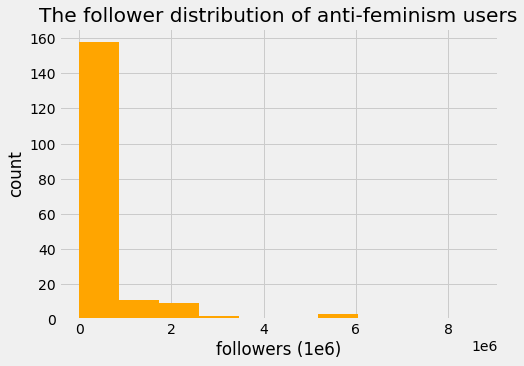

In [551]:
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(pro_qiangdong['followers'], color='orange')
plt.title("The follower distribution of anti-feminism users")
plt.xlabel("followers (1e6)")
plt.ylabel("count")
plt.show()

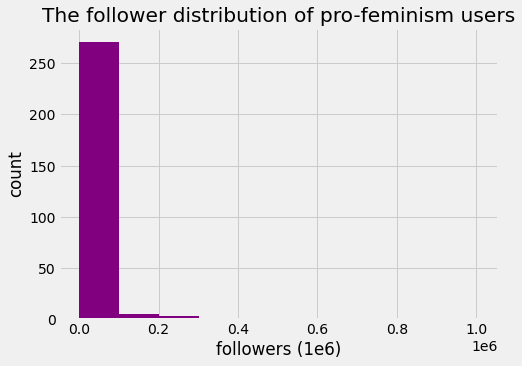

In [654]:
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(pro_jingyao['followers'], color='purple')
plt.title("The follower distribution of pro-feminism users")
plt.xlabel("followers (1e6)")
plt.ylabel("count")
plt.show()

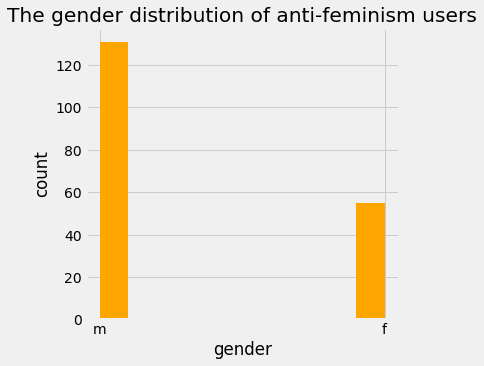

In [573]:
fig, ax = plt.subplots(figsize =(5, 5))
ax.hist(pro_qiangdong['gender'], color='orange')
plt.title("The gender distribution of anti-feminism users")
plt.xlabel("gender")
plt.ylabel("count")
plt.show()

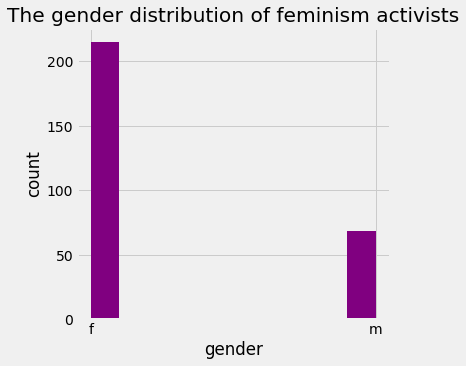

In [572]:
fig, ax = plt.subplots(figsize =(5, 5))
ax.hist(pro_jingyao['gender'], color='purple')
plt.title("The gender distribution of feminism activists")
plt.xlabel("gender")
plt.ylabel("count")
plt.show()

In [340]:
# 从edge list里过滤。。
# deleted_mid1 = pd.read_pickle(r'00pickles/deleted_mid1.pkl')
# deleted_mid2 = pd.read_pickle(r'00pickles/deleted_mid2.pkl')
# deleted_mid3 = pd.read_pickle(r'00pickles/deleted_mid3.pkl')
# deleted_mid4 = pd.read_pickle(r'00pickles/deleted_mid4.pkl')
# deleted_mid5 = pd.read_pickle(r'00pickles/deleted_mid5.pkl')
# deleted_mid6 = pd.read_pickle(r'00pickles/deleted_mid6.pkl')
# deleted_mid7 = pd.read_pickle(r'00pickles/deleted_mid7.pkl')
# deleted_mid8 = pd.read_pickle(r'00pickles/deleted_mid8.pkl')
# deleted_mid9 = pd.read_pickle(r'00pickles/deleted_mid9.pkl')

# combine一个大deleted_list
# import itertools
# deleted_list_ = itertools.chain(deleted_mid1, deleted_mid2, deleted_mid3, deleted_mid4, deleted_mid5, deleted_mid6, deleted_mid7, deleted_mid8, deleted_mid9, deleted_mid10, deleted_mid11, deleted_mid12, deleted_mid13, deleted_mid14, deleted_mid15)
# deleted_list = list(deleted_list_)

In [87]:
# # 收集那些要被删掉mid链条的源头

# root_original = pd.read_csv("liuqiangdong-hot/0th_原贴/original.csv")

# root_deleted = []
# for item in root_original['mid'].tolist():
#     if item not in root_df['mid'].tolist():
#         root_deleted.append(item)

In [279]:
root_deleted

[4784451895165509, 4784450733604916, 4498579441674492]

In [254]:
# # 合并每个文档下面的所有csv文件
# # 并抽走一些mid链条，比如不是热门但当时加进去的

# def combineData(folderName):
#     file_list = glob.glob("liuqiangdong-hot/" + folderName + "/*")
    
#     file_list_ = []
#     for item in file_list:
#         weishengjing = (
#             pd.read_csv(item)
#             .assign(
#                 root_mid = str(item).split('/')[2].replace(".csv","")
#             )
#             .loc[
#                 lambda x: x['forward_num'] > 0
#             ]
#         )
        

#         file_list_.append(weishengjing)

#     df = pd.concat(file_list_)
    
#     return df


# root_file_list_ = glob.glob("liuqiangdong-hot/*")
# root_file_list = []

# for item in root_file_list_:
#     root_file_list.append(item.split("/")[1])
    
    
# df_list = []
# for item in root_file_list:
#     if item != '0th_原贴':
#         df = combineData(item)
#         print(item +": done.")
#         df_list.append(df)

In [91]:
# root_file_list_ = glob.glob("liuqiangdong-hot/*")
# root_file_list = []

# for item in root_file_list_:
#     root_file_list.append(item.split("/")[1])
    
    
# df_list = []
# for item in root_file_list:
#     if item != '0th_原贴':
#         df = combineData(item)
#         print(item +": done.")
#         df_list.append(df)

In [155]:
# # 并抽走一些mid链条，比如不是热门但当时加进去的

# # based on 'root_deleted'

# def find_deleted_post(mid):
#     deleted_df = (
#         df
#         .loc[
#             lambda x: x['root_mid']== str(mid)
#         ]
#     )
    
#     return deleted_df

        
# for item in deleted_mid6:
#     deleted_df =  find_deleted_post(item)
    
#     for item in deleted_df['mid'].tolist():
#         deleted_mid7.append(item)


In [69]:
# 因为对root_df有一些改变，所以要删掉一些转发的点
# root_df中删掉了之前额外加进去的帖子


# root_mid_list = root_df['mid'].tolist()

# df = (
#     df
# )

In [161]:
## 储存了pickle!!!
# import pickle

# with open('00pickles/liuqiangdong_hot.pkl', 'wb') as f:
#      pickle.dump(df, f)

## Natural Language Analysis - Count Similarity
计算相似性 https://cloud.tencent.com/developer/article/1571874

In [9]:
import jieba
from gensim import corpora,models,similarities

# 加载用户词典
jieba.load_userdict("user_dict.txt")

# load stop words
stopwords = [k.strip() for k in open('stopwords.txt', encoding='utf8').readlines() if k.strip() != '']

In [10]:
# root文档，被对比的文档
root_df = (
    pd.read_csv("liuqiangdong-hot/0th_原贴/original_with.csv")
    .assign(
        content = lambda df:df['content'].apply(lambda x: re.sub(r'#(.*?)#', '', x))
    )
)

root_df.head(2)

,mid,user_name,type,link,content
0,4820093098264539,界面新闻,neutral,https://weibo.com/5182171545/M8qIdyFZ1?refer_f...,【】刘强东明州案迎来意外转折，北美时间10月1日晚间双方律师团队发表联合声明，声明显示案件双...
1,4820116920865457,界面新闻,pro-qiangdong,https://weibo.com/5182171545/M8rkE3D8Z?refer_f...,【】 界面新闻从刘强东律师处获悉，10月2日，刘强东就明州事件发表声明：纠葛四年的事情，今天...


In [396]:
# 支持jingyao
# root_jingyao = '.'.join(root_df[root_df['type']=='pro-jingyao']['content'].tolist())
# root_jingyao_list = [word for word in jieba.cut(root_jingyao) if word not in stopwords]

root_jingyao = '一位Jingyao的支持者在看到支持Jingyao的志愿者们把“solidarity with Jingyao，米兔运动永远前进”的横幅留在了明尼苏达的校园里之后写下的话。至少在今天 我们还有没有放弃希望，“希望是个动词”。'
root_jingyao_list = [word for word in jieba.cut(root_jingyao) if word not in stopwords]

In [399]:
root_jingyao

'一位Jingyao的支持者在看到支持Jingyao的志愿者们把“solidarity with Jingyao，米兔运动永远前进”的横幅留在了明尼苏达的校园里之后写下的话。至少在今天 我们还有没有放弃希望，“希望是个动词”。'

In [405]:
df = (
    pd.concat(df_list)
    .assign(
        content = lambda df:df['content'].apply(lambda x: re.sub(r'@(.*?):', '', x)).apply(lambda x: x.replace("转发微博","")).apply(lambda x: x.replace('Repost','')).apply(lambda x: x.replace("快转微博","")).apply(lambda x: re.sub(r'#(.*?)#', '', x))
    )
)

In [407]:
all_doc = []
for item in df['content'].tolist():
    all_doc.append(item)
    
# all_doc

In [408]:
all_doc_list = []
for doc in all_doc:
    doc_list = [word for word in jieba.cut(doc) if word not in stopwords]
    all_doc_list.append(doc_list)

In [409]:
# 制作语料库

dictionary = corpora.Dictionary(all_doc_list)
dictionary.keys()
dictionary.token2id

{'吃瓜': 0,
 '和解': 1,
 '事实确凿': 2,
 '人用': 3,
 '停止': 4,
 '吃': 5,
 '嘲讽': 6,
 '女生': 7,
 '庭审': 8,
 '怒': 9,
 '无罪': 10,
 '标题': 11,
 '污名化': 12,
 '瓜': 13,
 '表情': 14,
 '记录': 15,
 '请': 16,
 '里': 17,
 '10': 18,
 'doge': 19,
 '号': 20,
 '开庭': 21,
 '月': 22,
 '允悲': 23,
 '结': 24,
 '要告': 25,
 '说': 26,
 '强哥': 27,
 '挖': 28,
 '鼻': 29,
 '到位': 30,
 '爱': 31,
 '事儿': 32,
 '句号': 33,
 ' ': 34,
 'differences': 35,
 'jingyao': 36,
 'misunderstanding': 37,
 'set': 38,
 '不该': 39,
 '中': 40,
 '中文': 41,
 '事实': 42,
 '作': 43,
 '全名': 44,
 '公示': 45,
 '分歧': 46,
 '刘强东': 47,
 '参照': 48,
 '受害者': 49,
 '后文': 50,
 '声明': 51,
 '媒体': 52,
 '应是': 53,
 '引导性': 54,
 '强奸': 55,
 '法律': 56,
 '犯罪事实': 57,
 '畏罪': 58,
 '相当于': 59,
 '翻译成': 60,
 '英文稿': 61,
 '认罪': 62,
 '误会': 63,
 '达成': 64,
 '这篇': 65,
 '等于': 66,
 '贱': 67,
 '3000': 68,
 '不出': 69,
 '不想': 70,
 '亿美金': 71,
 '出身': 72,
 '小家子气': 73,
 '强东': 74,
 '当初': 75,
 '想': 76,
 '数': 77,
 '有种': 78,
 '沦为': 79,
 '男': 80,
 '睡': 81,
 '穷人': 82,
 '笑柄': 83,
 '给钱': 84,
 '美女': 85,
 '肯花': 86,
 '贼': 87,
 '赞': 88,
 '钱': 

In [410]:
corpus = [dictionary.doc2bow(doc) for doc in all_doc_list]

In [411]:
root_jingyao_vec = dictionary.doc2bow(root_jingyao_list)

In [412]:
# 使用TF-IDF模型对语料库建模

tfidf = models.TfidfModel(corpus)

In [413]:
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
sim = index[tfidf[root_jingyao_vec]]
sim

array([0.        , 0.01130206, 0.        , ..., 0.1205453 , 0.        ,
       0.01768753], dtype=float32)

In [414]:
len(sim)

6856

In [415]:
len(df)

6856

In [416]:
df['pro_jingyao_similarity'] = sim

In [420]:
df.sort_values(by='pro_jingyao_similarity', ascending=False)[1500:2050]

,mid,publish_time,user_name,user_link,content,weibo_link,forward_num,comment_num,like_num,root_mid,pro_jingyao_similarity
890,4821198041777843,2022-10-05 13:10:49,斯如composer,https://weibo.com/u/1457761154,开会没人接[允悲]//[吃瓜]//最右→_→//真正的良心//大佬里只有协和感染科的李太生主...,https://weibo.com/1457761154/M8Tso7suT,1,0,0,4820764726921195,0.018080
117,4821198041777843,2022-10-05 13:10:49,斯如composer,https://weibo.com/u/1457761154,开会没人接[允悲]//[吃瓜]//最右→_→//真正的良心//大佬里只有协和感染科的李太生主...,https://weibo.com/1457761154/M8Tso7suT,1,0,0,4821158559486602,0.018080
120,4821198041777843,2022-10-05 13:10:49,斯如composer,https://weibo.com/u/1457761154,开会没人接[允悲]//[吃瓜]//最右→_→//真正的良心//大佬里只有协和感染科的李太生主...,https://weibo.com/1457761154/M8Tso7suT,1,0,0,4821153539688821,0.018080
281,4820171015587327,2022-10-02 17:09:46,撕毛衣过冬肥成球,https://weibo.com/u/1732082475,////首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和...,https://weibo.com/1732082475/M8sJTnrwb,2,0,0,4820136555185309,0.017688
278,4820172311366946,2022-10-02 17:14:56,notedwithdllm,https://weibo.com/u/7454019430,//首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和解。...,https://weibo.com/7454019430/M8sLZ5JBw,1,0,0,4820136555185309,0.017688
...,...,...,...,...,...,...,...,...,...,...,...
254,4820193836271950,2022-10-02 18:40:28,躲雨的同伴,https://weibo.com/u/2132366912,////首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和...,https://weibo.com/2132366912/M8tkHqjCu,12,0,5,4820136555185309,0.017688
257,4820187323304483,2022-10-02 18:14:35,春空千鹤__,https://weibo.com/u/2860074462,首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和解。其次...,https://weibo.com/2860074462/M8tacdRE7,1,0,1,4820136555185309,0.017688
258,4820186773587984,2022-10-02 18:12:24,追风花美男ZYH,https://weibo.com/u/3980572030,//首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和解。...,https://weibo.com/3980572030/M8t9jf3oI,2,0,0,4820136555185309,0.017688
16,4820272434385290,2022-10-02 23:52:47,幺幺贰零贰八,https://weibo.com/u/5821100654,首先，达成法律和解的基础事实是认罪，这篇声明相当于是：刘强东在强奸犯罪事实下的畏罪和解。其次...,https://weibo.com/5821100654/M8vntioOu,1,0,2,4820144326971446,0.017688


In [26]:
# sorted(enumerate(sim), key=lambda item: -item[1])

## Build Node List

In [481]:
# node_list_ = list(set(df['mid'].tolist()))
# node_list = pd.DataFrame({'Id': node_list_, })

node_list_ = (
    df_keep_with_type[['mid','weibo_type']]
    .rename(
        columns={
            'mid':'Id',
        }
    )
)

node_list_.head()
# node_list.to_csv("liuqiangdong-hot-export/node_keep_list.csv", encoding="utf-8", index=False)

,Id,weibo_type
0,4820095886951506,pro_qiangdong
1,4820110622330529,pro_jingyao
2,4820114526705340,pro_qiangdong
3,4820097304102606,neutral
4,4820109014604185,pro_qiangdong


In [482]:
# 加入 root posts
# original posts

root_df = (
    pd.read_csv("liuqiangdong-hot/0th_原贴/original_with.csv")
    [['mid','type']]
    .rename(columns={'mid':'Id', 'type':'weibo_type'}) 
)

node_list = (
    node_list_.append(root_df)
    .assign(
        weibo_type = lambda df:df['weibo_type'].str.replace("-","_")
    )
    .loc[
        lambda x:x['weibo_type']!='deleted'
    ]
)

len(node_list)

528

In [487]:
len(root_df[root_df['weibo_type']!='deleted'])

29

In [483]:
set(node_list['weibo_type'].tolist())

{'neutral', 'pro_jingyao', 'pro_qiangdong'}

In [484]:
len(node_list)
node_list.to_csv("liuqiangdong-hot-export/00node_keep_list.csv", encoding="utf-8", index=False)

In [457]:
# 删除后的list!!

# node_list_deleted = (
#     node_list[~node_list['Id'].astype(int).isin(deleted_list)]
#     .reset_index(drop=True)
# )

# node_list.to_csv("liuqiangdong-hot-export/node_list_deleted.csv", encoding="utf-8", index=False)

## Build Edge list

In [576]:
edge_list = (
    df[['root_mid','mid']]
    .rename(columns={
        'root_mid':'Source',
        'mid':'Target'
    })
#     .loc[
#         lambda x:x['Source'].notnull() #去掉root的那些id
#     ]
    .reset_index(drop=True)
)

# edge_list.head()
# edge_list.to_csv("liuqiangdong-hot-export/edge_list_keep.csv", encoding="utf-8", index=False)

In [578]:
edge_list.head()

,Source,Target
0,4820093098264539,4820095886951506
1,4820093098264539,4820110622330529
2,4820093098264539,4820114526705340
3,4820093098264539,4820097304102606
4,4820093098264539,4820109014604185


In [620]:
# 尝试解决triangle situation

edge_list.drop_duplicates(subset=['Target'], keep="first").sort_values(by='Target', ascending=True).reset_index(drop=True).to_csv("liuqiangdong-hot-export/edge_list2.csv", encoding="utf-8", index=False)

In [614]:
df[df['mid']==4498581471461564]

,mid,publish_time,user_name,user_link,content,weibo_link,forward_num,comment_num,like_num,root_mid,pro_jingyao_similarity
904,4498581471461564,2020-04-28 07:07:45,Kiyomizudera,https://weibo.com/u/6256149932,✌️//🎆🎆🎆//京东欲切割刘强东个人行为，法院驳回！,https://weibo.com/6256149932/IFmyn68dC,4,0,1,4498579441674492,0.0
372,4498581471461564,2020-04-28 07:07:45,Kiyomizudera,https://weibo.com/u/6256149932,✌️//🎆🎆🎆//京东欲切割刘强东个人行为，法院驳回！,https://weibo.com/6256149932/IFmyn68dC,4,0,1,4498580544866705,0.0


In [615]:
df[df['mid']==4498580544866705]

,mid,publish_time,user_name,user_link,content,weibo_link,forward_num,comment_num,like_num,root_mid,pro_jingyao_similarity
0,4498580544866705,2020-04-28 07:04:04,Gawiel,https://weibo.com/u/1890609644,京东欲切割刘强东个人行为，法院驳回！,https://weibo.com/1890609644/IFmwSkq3f,610,0,30,4498579441674492,0.0


In [582]:
## add directions to root ids

root_df_id = root_df['Id'].tolist()
edge_list[edge_list['Source'].astype(int).isin(root_df_id)]

,Source,Target
0,4820093098264539,4820095886951506
1,4820093098264539,4820110622330529
2,4820093098264539,4820114526705340
3,4820093098264539,4820097304102606
4,4820093098264539,4820109014604185
...,...,...
1215,4820764726921195,4820770414398908
1216,4820764726921195,4820768498912615
1217,4820764726921195,4820767436703897
1218,4820764726921195,4820766590240124


## Build Label list

In [85]:
label_list = (
    df[['mid','user_name']]
    .rename(columns={
        'mid':'Id',
        'user_name':'Label'
    })
)
label_list.head()
# label_list.to_csv("liuqiangdong-hot-export/label_list.csv", encoding="utf-8", index=False)